In [1]:
from google.colab import drive

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# read mr and ct datasets
MR_train_address = 'drive/MyDrive/MR_CT_data/train_input.npy'
CT_train_address = 'drive/MyDrive/MR_CT_data/train_output.npy'

MR_val_address = 'drive/MyDrive/MR_CT_data/val_input.npy'
CT_val_address = 'drive/MyDrive/MR_CT_data/val_output.npy'

MR_test_address = 'drive/MyDrive/MR_CT_data/test_input.npy'
CT_test_address = 'drive/MyDrive/MR_CT_data/test_output.npy'

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

In [5]:
ct_train.shape, ct_val.shape, ct_test.shape

((570, 256, 256), (90, 256, 256), (150, 256, 256))

In [6]:
# resizes a 1d numpy array to an arbitrary size
def resize(img, size):

  img = img.astype('float32')
  img = torch.tensor(img)
  img = img.unsqueeze(0)

  transform = T.Resize(size, antialias=False)
  resized_img = transform(img)

  # resized_img = np.array(resized_img)

  return resized_img

In [7]:
change_gray_level = T.Compose([
    T.Lambda(lambda t: t * 0.2)
])

horizontal_flip = T.Compose([
    T.functional.hflip
])

vertical_flip = T.Compose([
    T.functional.vflip
])

rotate_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=45))
])

rotate_minus_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=-45))
])

In [8]:
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

# remove 90 samples from test data and add it to train data
n_add_from_test_to_train = 90

n_train_new = n_train_samples + n_val_samples + n_add_from_test_to_train
n_test_new = n_test_samples - n_add_from_test_to_train

# data augmentation
# add 5 varient of each sample
# so our train dataset will be 6 times bigger
n_train_new = n_train_new * 6

mr_train_resized = [None] * n_train_new
ct_train_resized = [None] * n_train_new

mr_test_resized = [None] * n_test_new
ct_test_resized = [None] * n_test_new

# train samples with augmentation
for i in range(n_train_samples):

  j = i * 6

  resized_mr = resize(mr_train[i], 64)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_train[i], 64)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)


# validation samples with augmentation
for i in range(n_val_samples):

  j = i*6 + n_train_samples*6

  resized_mr = resize(mr_val[i], 64)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_val[i], 64)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)


# part of test samples with augmentation

for i in range(n_add_from_test_to_train):

  j = i*6 + n_train_samples*6 + n_val_samples*6

  resized_mr = resize(mr_test[i], 64)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_test[i], 64)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)

# test samples
for i in range(n_test_new):

  j = i + n_add_from_test_to_train

  mr_test_resized[i] = resize(mr_test[j], 64)
  ct_test_resized[i] = resize(ct_test[j], 64)

In [9]:
# convert train and test samples to numpy array
for i in range(n_train_new):
  mr_train_resized[i] = np.array(mr_train_resized[i])
  ct_train_resized[i] = np.array(ct_train_resized[i])

for i in range(n_test_new):
  mr_test_resized[i] = np.array(mr_test_resized[i])
  ct_test_resized[i] = np.array(ct_test_resized[i])

In [10]:
# convert lists of mr and ct to tensors
mr_train_resized = np.array(mr_train_resized)
mr_train_resized = torch.tensor(mr_train_resized)

ct_train_resized = np.array(ct_train_resized)
ct_train_resized = torch.tensor(ct_train_resized)

mr_test_resized = np.array(mr_test_resized)
mr_test_resized = torch.tensor(mr_test_resized)

ct_test_resized = np.array(ct_test_resized)
ct_test_resized = torch.tensor(ct_test_resized)

print('train images shape:', mr_train_resized.shape)
print('test images shape:', mr_test_resized.shape)

train images shape: torch.Size([4500, 1, 64, 64])
test images shape: torch.Size([60, 1, 64, 64])


In [11]:
# Set up your training dataset and dataloader
train_dataset = TensorDataset(mr_train_resized, ct_train_resized)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Set up your testing dataset and dataloader
test_dataset = TensorDataset(mr_test_resized, ct_test_resized)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * s

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c, out_c)
        self.c1 = conv_block(in_c[0]+out_c, out_c)

    def forward(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.c1(x)
        return x

class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)

        self.b1 = conv_block(256, 512)

        self.d1 = decoder_block([512, 256], 256)
        self.d2 = decoder_block([256, 128], 128)
        self.d3 = decoder_block([128, 64], 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)

        b1 = self.b1(p3)

        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output(d3)
        return output

In [13]:
# model = attention_unet()
# model.to(device)

# for i, (inputs, targets) in enumerate(train_loader):

#   inputs = inputs.to(device)
#   targets = targets.to(device)

#   # print(inputs.shape)

#   outputs = model(inputs)

#   print(outputs.shape)

#   if i == 0:
#     break

In [14]:
# # Define the DiffusionModel architecture
# class DiffusionModel(nn.Module):
#   def __init__(self, in_channels, out_channels, diffusion_steps):
#     super(DiffusionModel, self).__init__()

#     self.diffusion_steps = diffusion_steps

#     # Encoder
#     self.encoder = nn.Sequential(
#         nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(256, 64, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(64, 64, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=2, stride=2),
#     )


#     # Decoder
#     self.decoder = nn.Sequential(
#         nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(64, 64, kernel_size=2, stride=2),
#         nn.ConvTranspose2d(64, 256, kernel_size=2, stride=2),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(256, out_channels, kernel_size=3, padding=1),
#         nn.Tanh()
# )

#     # Noise Generator
#     self.noise_generator = nn.Sequential(
#         nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#         nn.Tanh()
#     )

#   def forward(self, mri_image):

#     # Pass the MRI image through the encoder
#     encoded = self.encoder(mri_image)

#     # Initialize the CT image as the encoded MRI image
#     ct_image = encoded

#     # # Perform diffusion steps
#     # for _ in range(self.diffusion_steps):
#       # # Generate noise
#       # noise = self.noise_generator(ct_image)

#       # # Add noise to the CT image
#       # ct_image = ct_image + noise

#       # # Pass the CT image through the decoder
#       # ct_image = self.decoder(ct_image)
#     ct_image = self.decoder(ct_image)

#     return ct_image

# Define the training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
  model.train()

  step_size = 1

  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):

      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    if (epoch+1) == 1 or (epoch+1) % step_size == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


# Example usage

in_channels = 1  # Number of input channels (grayscale MRI image)
out_channels = 1  # Number of output channels (grayscale CT image)

diffusion_steps = 5  # Number of diffusion steps
num_epochs = 200  # Number of training epochs
learning_rate = 0.001  # Learning rate


# Create an instance of the DiffusionModel
# model = DiffusionModel(in_channels, out_channels, diffusion_steps)
# model.to(device)
# Create an instance of the attention unet model
model = attention_unet()
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/200], Loss: 0.0212
Epoch [2/200], Loss: 0.0090
Epoch [3/200], Loss: 0.0070
Epoch [4/200], Loss: 0.0071
Epoch [5/200], Loss: 0.0053
Epoch [6/200], Loss: 0.0055
Epoch [7/200], Loss: 0.0052
Epoch [8/200], Loss: 0.0047
Epoch [9/200], Loss: 0.0051
Epoch [10/200], Loss: 0.0048
Epoch [11/200], Loss: 0.0046
Epoch [12/200], Loss: 0.0042
Epoch [13/200], Loss: 0.0041
Epoch [14/200], Loss: 0.0038
Epoch [15/200], Loss: 0.0040
Epoch [16/200], Loss: 0.0049
Epoch [17/200], Loss: 0.0049
Epoch [18/200], Loss: 0.0043
Epoch [19/200], Loss: 0.0037
Epoch [20/200], Loss: 0.0036
Epoch [21/200], Loss: 0.0035
Epoch [22/200], Loss: 0.0034
Epoch [23/200], Loss: 0.0034
Epoch [24/200], Loss: 0.0033
Epoch [25/200], Loss: 0.0032
Epoch [26/200], Loss: 0.0033
Epoch [27/200], Loss: 0.0033
Epoch [28/200], Loss: 0.0034
Epoch [29/200], Loss: 0.0041
Epoch [30/200], Loss: 0.0044
Epoch [31/200], Loss: 0.0033
Epoch [32/200], Loss: 0.0032
Epoch [33/200], Loss: 0.0032
Epoch [34/200], Loss: 0.0031
Epoch [35/200], Loss: 0

In [15]:
# After training the model
saved_model_path = f"drive/MyDrive/MR_CT_model/model_weights_epochs_{num_epochs}.pth"
torch.save(model.state_dict(), saved_model_path)

In [16]:
outputs_save_dir = 'drive/MyDrive/MR_CT_outputs'
outputs_save_folder = os.path.join(outputs_save_dir, f'epochs_{num_epochs}_')
os.mkdir(outputs_save_folder)

# Define the testing loop
def test_model(model, test_loader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):

      inputs = inputs.to(device)
      targets = targets.to(device)
      # Forward pass
      outputs = model(inputs)

      outputs_save_filename = f'outputs_batch{i}'
      outputs_save_path = os.path.join(outputs_save_folder, outputs_save_filename)

      np.save(outputs_save_path, np.array(outputs.cpu()))

      # Compute the loss
      loss = criterion(outputs, targets)

      total_loss += loss.item()

  avg_loss = total_loss / len(test_loader)
  print(f"Average Loss: {avg_loss:.4f}")

# Example usage
in_channels = 1  # Number of input channels (grayscale MRI image)
out_channels = 1  # Number of output channels (grayscale CT image)
diffusion_steps = 5  # Number of diffusion steps

# Load the trained model weights
# model = DiffusionModel(in_channels, out_channels, diffusion_steps)
model = attention_unet()
model.to(device)
model.load_state_dict(torch.load(saved_model_path))


# model = model.load_state_dict(torch.load(saved_model_path))

# Define the loss function
criterion = nn.MSELoss()

# Test the model
test_model(model, test_loader, criterion)

Average Loss: 0.0651


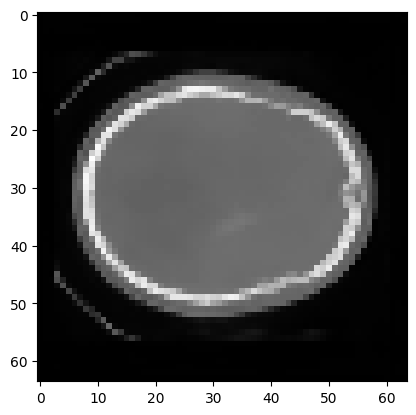

In [17]:
batch_number = 0

outputs_save_filename = f'outputs_batch{batch_number}.npy'
saved_outputs = os.path.join(outputs_save_folder, outputs_save_filename)

outputs = np.load(saved_outputs)

n_samples = 1

for i in range(n_samples):
  output = outputs[i]
  output = np.reshape(output, (64, 64, 1))
  plt.imshow(output, cmap='gray')
  plt.show()

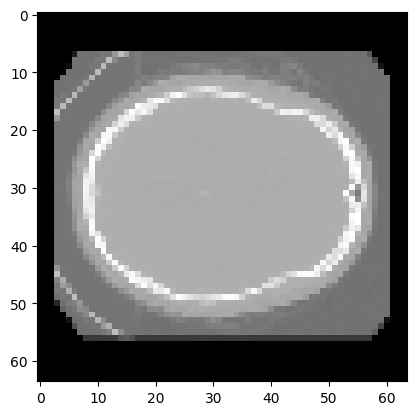

In [18]:
test_sample = ct_test_resized[0]
test_sample = np.reshape(test_sample, (64, 64, 1))
plt.imshow(test_sample, cmap='gray')